In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json

import sys
sys.path.append('../0 utils/')
from tool import *

import matplotlib.pyplot as plt



data_root = '../../MyData/'

## Load data

In [2]:
item1_embedding = pd.read_csv(data_root+'merged_1197.csv')
item1_embedding = item1_embedding[['cik', 'tic', 'Year', 'item1_embeddings']]
print(len(item1_embedding))
print(item1_embedding.head())

other_embedding = pd.read_csv(data_root+'output_embeddings_2.csv')
other_embedding = other_embedding[['cik', 'SP_SHORT_DESC_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']]
print(len(other_embedding))
print(other_embedding.head())

total_embedding = pd.merge(item1_embedding, other_embedding, on=['cik'])

# To reduce mem consumption
item1_embedding = ''
other_embedding = ''

print(len(total_embedding))
total_embedding.head()

1197
       cik   tic  Year                                   item1_embeddings
0   850460  WIRE  2021  [0.03955410048365593, -0.04159577935934067, -0...
1   352541   LNT  2021  [-0.0231856107711792, 0.001279839314520359, 0....
2  1704715   AMR  2021  [0.014074714854359627, 0.006938479840755463, 0...
3  1575515   SFM  2021  [-0.023708730936050415, 0.01762891560792923, 0...
4  1125376  ENSG  2021  [0.04463111609220505, 0.0018805989529937506, 0...
1197
       cik                           SP_SHORT_DESC_embeddings  \
0   850460  [0.01568225771188736, -0.07636360824108124, -0...   
1   352541  [-0.013836896046996117, -0.028995024040341377,...   
2  1704715  [0.0030535957776010036, 0.0008783274097368121,...   
3  1575515  [-0.025762900710105896, 0.0034106436651200056,...   
4  1125376  [0.04616139456629753, -0.0021259395871311426, ...   

                             SP_LONG_DESC_embeddings  \
0  [0.06089901179075241, -0.07059630751609802, -0...   
1  [-0.021961161866784096, 0.02030270546674

,cik,tic,Year,item1_embeddings,SP_SHORT_DESC_embeddings,SP_LONG_DESC_embeddings,ORBIS_PROD_SERV_embeddings,ORBIS_OVERVIEW_embeddings
0,850460,WIRE,2021,"[0.03955410048365593, -0.04159577935934067, -0...","[0.01568225771188736, -0.07636360824108124, -0...","[0.06089901179075241, -0.07059630751609802, -0...",NaN,NaN
1,352541,LNT,2021,"[-0.0231856107711792, 0.001279839314520359, 0....","[-0.013836896046996117, -0.028995024040341377,...","[-0.021961161866784096, 0.020302705466747284, ...","[-0.015400929376482964, 0.03232719004154205, -...","[-0.041709959506988525, -0.011898815631866455,..."
2,1704715,AMR,2021,"[0.014074714854359627, 0.006938479840755463, 0...","[0.0030535957776010036, 0.0008783274097368121,...","[-0.0017570963827893138, 0.006557094398885965,...","[-0.02030838653445244, -0.009386725723743439, ...","[-0.012340557761490345, -0.01428779773414135, ..."
3,1575515,SFM,2021,"[-0.023708730936050415, 0.01762891560792923, 0...","[-0.025762900710105896, 0.0034106436651200056,...","[-0.015190708450973034, 0.011541897431015968, ...","[-0.013177500106394291, 0.036401789635419846, ...","[-0.01883152313530445, 0.021741388365626335, 0..."
4,1125376,ENSG,2021,"[0.04463111609220505, 0.0018805989529937506, 0...","[0.04616139456629753, -0.0021259395871311426, ...","[0.05935207009315491, 0.0013673527864739299, 0...","[0.029405493289232254, 0.014010551385581493, 0...","[-0.006068837363272905, 0.010537531226873398, ..."


### Check dataset

In [3]:
nan_proportion = total_embedding.isna().mean()
print(f"The nan value proportion in each column:\n{nan_proportion}\n\n")

The nan value proportion in each column:
cik                           0.000000
tic                           0.000000
Year                          0.000000
item1_embeddings              0.000000
SP_SHORT_DESC_embeddings      0.041771
SP_LONG_DESC_embeddings       0.095238
ORBIS_PROD_SERV_embeddings    0.208020
ORBIS_OVERVIEW_embeddings     0.168755
dtype: float64




## Define fusion function

In [33]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, embedding_dim, latent_dim, noise_factor=0.1):
        super(DenoisingAutoencoder, self).__init__()
        self.noise_factor = noise_factor
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, latent_dim),
            # nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, embedding_dim),
            nn.Tanh()
        )
    
    def add_gaussian_noise(self, input_tensor):
        """
        Adds Gaussian noise to the input tensor.

        Parameters:
        - input_tensor: The tensor to which noise will be added.
        - mean: The mean of the Gaussian distribution (default: 0.0).
        - std: The standard deviation of the Gaussian distribution

        Returns:
        - Tensor with added Gaussian noise.
        """
        # Generate Gaussian noise
        noise = torch.normal(mean=0, std=1, size=input_tensor.size(), dtype=input_tensor.dtype)
        
        # Add noise to the input tensor
        noisy_input = input_tensor + noise*self.noise_factor
        
        return noisy_input
    
    def forward(self, x):
        if self.training:
            myInput = self.add_gaussian_noise(x)
        else:
            myInput = x

        latent = self.encoder(myInput)
        reconstructed = self.decoder(latent)
        return reconstructed




In [5]:
def train_autoencoder(train_loader, test_loader, embedding_dim, latent_dim, epochs=10, noise_factor=0.1):
    model = DenoisingAutoencoder(embedding_dim, latent_dim, noise_factor)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):

        model.train()
        train_loss = 0
        for batch in train_loader:
            inputs = batch[0].float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            

        avg_train_loss = train_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss * 10000: {avg_train_loss*10000:.4f}')


        # Testing Phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                inputs = batch[0].float()

                outputs = model(inputs)
                loss = criterion(outputs, inputs).item()
                test_loss += loss

        avg_test_loss = test_loss / len(test_loader)
        print(f'Epoch {epoch+1}, Testing Loss * 10000: {avg_test_loss*10000:.4f}\n')

    return model


In [6]:
def show_autoencoder_res(model, test_loader):
    criterion = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            temp_point = batch[0][5:10].float()

            temp_output = model(temp_point)
            print(criterion(temp_output, temp_point))
            break
    
    for i in range(5):
        l1 = temp_point[i][0]
        l2 = temp_output[i][0]

        plt.figure(figsize=(5, 3))

        plt.plot(l1, alpha=0.5, label="original data")
        plt.plot(l2, alpha=0.5, label="model output")

        plt.xlim(300, 400)
        # plt.ylim(-0.05, 0.2)
        plt.legend()

        plt.show()

In [7]:
def concatenate_fusion(data_df, target_list):
    modality_content_list = []
    for target in target_list:
        temp_list = list(data_df[target].apply(json.loads))
        modality_content_list.append(temp_list)

    modality_content_array = np.array(modality_content_list)  # Shape: (3, 1197, 1536)

    arr_transposed = np.transpose(modality_content_array, (1, 0, 2))  # Shape: (1197, 3, 1536)
    arr_shape = arr_transposed.shape

    # Reshape the last two dimensions into a single dimension
    result = arr_transposed.reshape(arr_shape[0], arr_shape[1]*arr_shape[2])
    
    return result

In [8]:
# Fusion function that can handle nan modalities
def additive_fusion(data_df, target_list):
    modality_content_list = []
    # Traverse columns that will be fused.
    for target in target_list:
        modality_content_list.append(list(data_df[target].apply(
            lambda x: json.loads(x) if pd.notna(x) else np.full(1536, np.nan)
            )))
    
    # Convert to a NumPy array
    modality_content_array = np.array(modality_content_list)  # Shape: (3, 1197, 1536)
    
    # Create a mask for valid (non-NaN) values
    valid_mask = ~np.isnan(modality_content_array)  # Shape: (3, 1197, 1536)
    
    # Replace NaN with 0 for summation
    modality_content_array = np.nan_to_num(modality_content_array, nan=0.0)
    
    # Sum along modalities (axis=0) and count valid values
    summed_features = np.sum(modality_content_array, axis=0)  # Shape: (1197, 1536)
    valid_counts = np.sum(valid_mask, axis=0)  # Shape: (1197, 1536)
    
    # Avoid division by zero and calculate the average
    average_features = summed_features / np.maximum(valid_counts, 1)
    
    return average_features

## Experient 1:

Concatenate item1, sp_long, orbis_overview

### Train

In [34]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year']
exp1_df = total_embedding[info_list + target_list]
exp1_df = exp1_df.dropna(how='any')

concatenated_np = concatenate_fusion(exp1_df, target_list)
print(concatenated_np.shape)
concatenated_np

(926, 4608)


array([[-0.02318561,  0.00127984,  0.03837442, ..., -0.01639827,
        -0.00884627,  0.01504294],
       [ 0.01407471,  0.00693848,  0.05793545, ..., -0.01053198,
        -0.01884542,  0.01698861],
       [-0.02370873,  0.01762892,  0.03881923, ...,  0.00984779,
         0.01709069, -0.00222528],
       ...,
       [-0.02168068,  0.02275101,  0.01675978, ...,  0.00697548,
         0.00930723, -0.00699524],
       [ 0.02060029,  0.01415954,  0.02986284, ...,  0.00881959,
        -0.01525622, -0.00635244],
       [-0.06847923, -0.00438687,  0.04645469, ..., -0.0006741 ,
        -0.00551236,  0.0016899 ]])

In [35]:
from torch.utils.data import DataLoader, TensorDataset, random_split

concatenated_ts = torch.tensor(concatenated_np).unsqueeze(1)
print(concatenated_ts.size())

# Wrap the tensor in a TensorDataset
dataset = TensorDataset(concatenated_ts)

# Split into training and testing datasets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([926, 1, 4608])


Epoch 1, Training Loss * 10000: 4.3854
Epoch 1, Testing Loss * 10000: 3.6088

Epoch 2, Training Loss * 10000: 3.5799
Epoch 2, Testing Loss * 10000: 3.5472

Epoch 3, Training Loss * 10000: 3.5421
Epoch 3, Testing Loss * 10000: 3.5109

Epoch 4, Training Loss * 10000: 3.4565
Epoch 4, Testing Loss * 10000: 3.3839

Epoch 5, Training Loss * 10000: 3.3514
Epoch 5, Testing Loss * 10000: 3.2982

Epoch 6, Training Loss * 10000: 3.2907
Epoch 6, Testing Loss * 10000: 3.2371

Epoch 7, Training Loss * 10000: 3.2423
Epoch 7, Testing Loss * 10000: 3.1803

Epoch 8, Training Loss * 10000: 3.1931
Epoch 8, Testing Loss * 10000: 3.1539

Epoch 9, Training Loss * 10000: 3.1614
Epoch 9, Testing Loss * 10000: 3.1318

Epoch 10, Training Loss * 10000: 3.1388
Epoch 10, Testing Loss * 10000: 3.1153

tensor(0.0003)


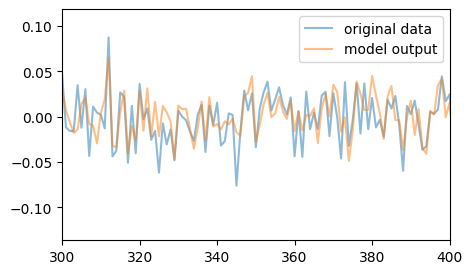

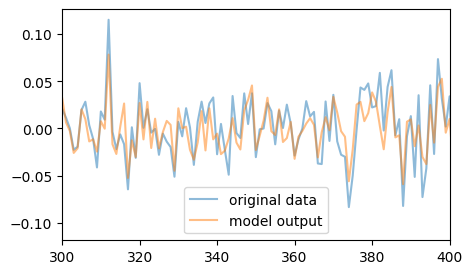

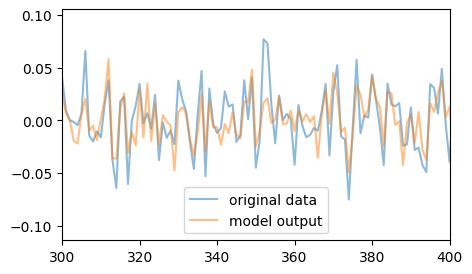

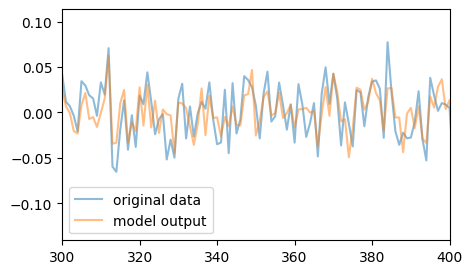

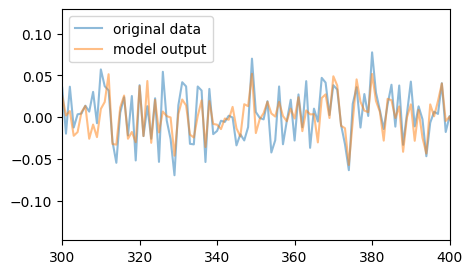

In [36]:
model = train_autoencoder(train_loader, test_loader, 4608, 256)
show_autoencoder_res(model, test_loader)

#### Old version of training code

In [12]:
# # Example initialization
# embedding_dim = 4608  # Example transformer embedding dimension
# latent_dim = 256     # Latent space dimension
# noise_factor = 0.1     # Standard deviation of Gaussian noise

# model = DenoisingAutoencoder(embedding_dim, latent_dim, noise_factor)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# # Training loop
# epochs = 10

# for epoch in range(epochs):

#     model.train()
#     train_loss = 0
#     for batch in train_loader:
#         inputs = batch[0].float()  # Get the batch

#         optimizer.zero_grad()
#         outputs = model(inputs)  # Forward pass
#         loss = criterion(outputs, inputs)  # Compute loss
#         train_loss += loss.item()
#         loss.backward()
#         optimizer.step()
        

#     avg_train_loss = train_loss / len(train_loader)
#     print(f'Epoch {epoch+1}, Training Loss * 10000: {avg_train_loss*10000:.4f}')


#     # Testing Phase
#     model.eval()
#     test_loss = 0.0
#     with torch.no_grad():
#         for batch in test_loader:
#             inputs = batch[0].float()

#             outputs = model(inputs)
#             loss = criterion(outputs, inputs).item()
#             test_loss += loss

#     avg_test_loss = test_loss / len(test_loader)
#     print(f'Epoch {epoch+1}, Testing Loss * 10000: {avg_test_loss*10000:.4f}\n')


In [13]:
# model.eval()
# with torch.no_grad():
#     for batch in test_loader:
#         temp_point = batch[0][5:10].float()

#         temp_output = model(temp_point)
#         print(criterion(temp_output, temp_point))
#         break

In [14]:

# temp_point = temp_point[~temp_mask]
# temp_output = temp_output[~temp_mask]

# for i in range(5):
#     l1 = temp_point[i][0]
#     l2 = temp_output[i][0]

#     plt.figure(figsize=(10, 6))

#     plt.plot(l1, alpha=0.5, label="original data")
#     plt.plot(l2, alpha=0.5, label="model output")

#     plt.xlim(300, 400)
#     # plt.ylim(-0.05, 0.2)
#     plt.legend()

#     plt.show()

### Clustering

In [37]:
model.eval()
with torch.no_grad():
    encoded_ts = model.encoder(concatenated_ts.float())
    encoded_ts = encoded_ts.squeeze(1)
    print(encoded_ts.size())
    print(encoded_ts)

torch.Size([926, 256])
tensor([[-0.0813, -0.0232, -0.0141,  ...,  0.0489, -0.0322,  0.0019],
        [-0.0641, -0.0440, -0.0136,  ...,  0.0421, -0.0331,  0.0203],
        [-0.0287, -0.0140, -0.0247,  ..., -0.0212, -0.0230,  0.0424],
        ...,
        [-0.0381, -0.0230, -0.0004,  ...,  0.0133, -0.0443,  0.0370],
        [-0.0347, -0.0088,  0.0055,  ...,  0.0028, -0.0246,  0.0187],
        [-0.0407, -0.0123,  0.0020,  ...,  0.0113, -0.0298,  0.0129]])


In [38]:
exp1_df = exp1_df[['cik', 'tic', 'Year']]

exp1_df['cluster_10'] = cluster(encoded_ts, 10)
exp1_df['cluster_100'] = cluster(encoded_ts, 100)
exp1_df

Normalized Within-Cluster Sum of Squares (WCSS): 5.982783230798034e-05
Normalized Within-Cluster Sum of Squares (WCSS): 1.4337955432950035e-05


,cik,tic,Year,cluster_10,cluster_100
1,352541,LNT,2021,3,3
2,1704715,AMR,2021,7,77
3,1575515,SFM,2021,8,30
4,1125376,ENSG,2021,6,32
5,1674335,JELD,2021,2,65
...,...,...,...,...,...
1190,1653653,RRR,2021,6,57
1191,1627223,CC,2021,0,89
1192,1021860,NOV,2021,7,28
1193,1744489,DIS,2021,6,51


In [41]:
# exp1_df.to_csv('4_concat-auto_clusters.csv', index=False)

### Evaluate

In [39]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
# returns_long = fetch_stock_data(exp1_df, year, mode)
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp1_returns = pd.merge(exp1_df, returns_long, on='tic', how='inner')

exp1_intra_corrs_10 = intra_industry_correlations(exp1_returns, "cluster_10")
exp1_avg_intra_corr_10 = np.nanmean(list(exp1_intra_corrs_10.values()))
print(exp1_avg_intra_corr_10)

exp1_intra_corrs_100 = intra_industry_correlations(exp1_returns, "cluster_100")
exp1_avg_intra_corr_100 = np.nanmean(list(exp1_intra_corrs_100.values()))
print(exp1_avg_intra_corr_100)

print(len(exp1_returns['cik'].unique()))

0.381367053133194
0.42113272103950494
924


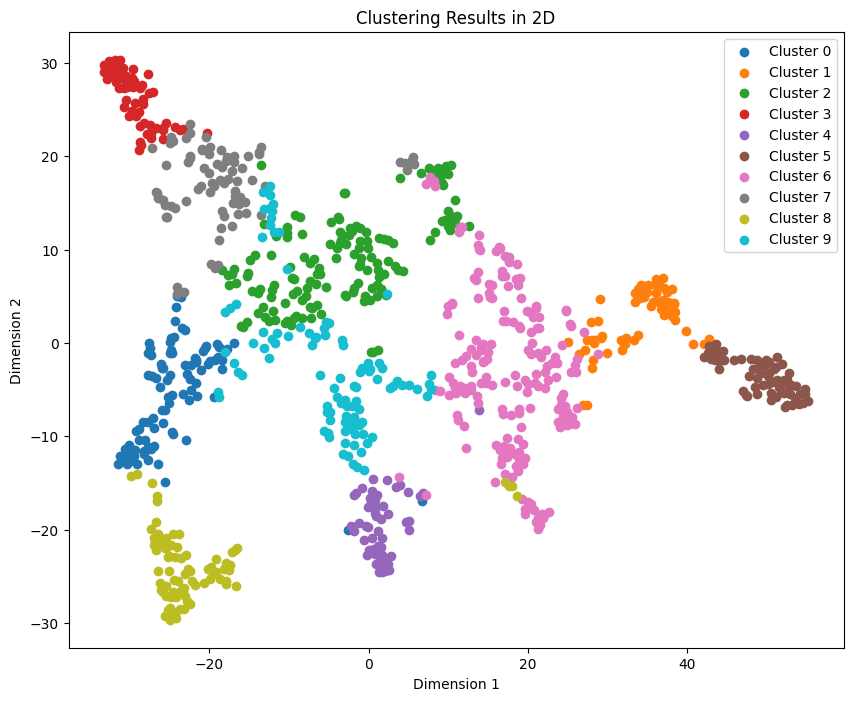

In [40]:
show_cluster_graph(encoded_ts, exp1_df['cluster_10'])

## Experient 2:

Using the mean of item1, sp_long, orbis_overview

In [42]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_OVERVIEW_embeddings']
fused_np = additive_fusion(total_embedding, target_list)
print(fused_np.shape)

(1197, 1536)


In [43]:
from torch.utils.data import DataLoader, TensorDataset, random_split

fused_ts = torch.tensor(fused_np).unsqueeze(1)
print(fused_ts.size())

# Wrap the tensor in a TensorDataset
dataset = TensorDataset(fused_ts)

# Split into training and testing datasets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([1197, 1, 1536])


Epoch 1, Training Loss * 10000: 3.4154
Epoch 1, Testing Loss * 10000: 4.0470

Epoch 2, Training Loss * 10000: 2.8207
Epoch 2, Testing Loss * 10000: 3.3798

Epoch 3, Training Loss * 10000: 2.7858
Epoch 3, Testing Loss * 10000: 3.2027

Epoch 4, Training Loss * 10000: 2.7115
Epoch 4, Testing Loss * 10000: 2.9200

Epoch 5, Training Loss * 10000: 2.6510
Epoch 5, Testing Loss * 10000: 2.9097

Epoch 6, Training Loss * 10000: 2.5967
Epoch 6, Testing Loss * 10000: 2.8517

Epoch 7, Training Loss * 10000: 2.5545
Epoch 7, Testing Loss * 10000: 2.7079

Epoch 8, Training Loss * 10000: 2.5192
Epoch 8, Testing Loss * 10000: 2.6311

Epoch 9, Training Loss * 10000: 2.4831
Epoch 9, Testing Loss * 10000: 2.5708

Epoch 10, Training Loss * 10000: 2.4734
Epoch 10, Testing Loss * 10000: 2.5307

tensor(0.0002)


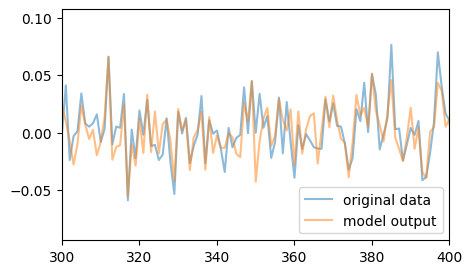

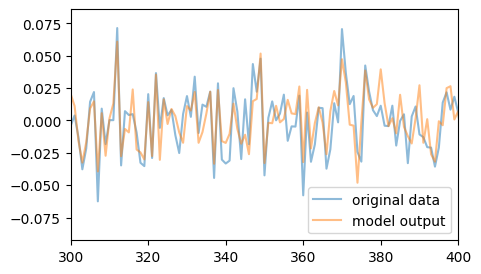

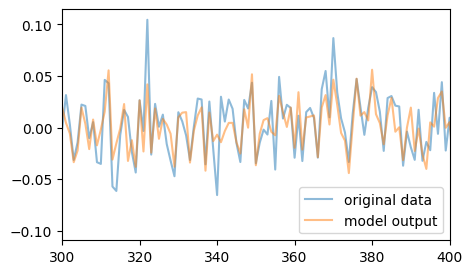

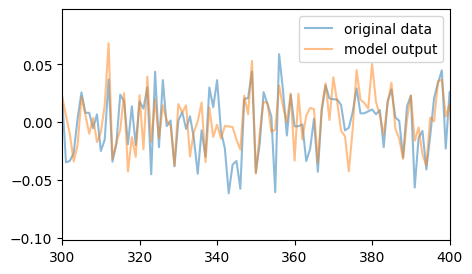

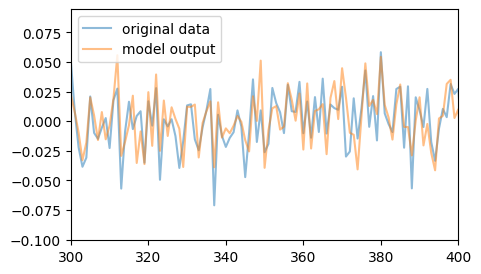

In [44]:
model = train_autoencoder(train_loader, test_loader, 1536, 256)
show_autoencoder_res(model, test_loader)

### Clustering

In [45]:
model.eval()
with torch.no_grad():
    encoded_ts = model.encoder(fused_ts.float())
    encoded_ts = encoded_ts.squeeze(1)
    print(encoded_ts.size())
    print(encoded_ts)

torch.Size([1197, 256])
tensor([[-0.0183, -0.0175,  0.0261,  ..., -0.0020,  0.0192, -0.0369],
        [-0.0348, -0.0468, -0.0017,  ..., -0.0374, -0.0133, -0.0256],
        [-0.0207, -0.0264,  0.0019,  ..., -0.0201, -0.0093, -0.0272],
        ...,
        [ 0.0128, -0.0369,  0.0679,  ..., -0.0050,  0.0208, -0.0337],
        [-0.0114, -0.0213,  0.0391,  ..., -0.0076,  0.0277, -0.0508],
        [-0.0102, -0.0064,  0.0301,  ...,  0.0187,  0.0036, -0.0257]])


In [46]:
exp2_df = total_embedding[['cik', 'tic', 'Year']].copy()
exp2_df['cluster_10'] = cluster(encoded_ts, 10)
exp2_df['cluster_100'] = cluster(encoded_ts, 100)
exp2_df

Normalized Within-Cluster Sum of Squares (WCSS): 4.918287907327924e-05
Normalized Within-Cluster Sum of Squares (WCSS): 1.2273313563220583e-05


,cik,tic,Year,cluster_10,cluster_100
0,850460,WIRE,2021,9,54
1,352541,LNT,2021,6,3
2,1704715,AMR,2021,2,60
3,1575515,SFM,2021,0,35
4,1125376,ENSG,2021,7,42
...,...,...,...,...,...
1192,1021860,NOV,2021,4,75
1193,1744489,DIS,2021,7,49
1194,1102112,PACW,2021,3,84
1195,28823,DBD,2021,8,90


In [49]:
# exp2_df.to_csv('4_avg-auto_clusters.csv', index=False)

In [47]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
# returns_long = fetch_stock_data(exp2_df, year, mode)
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp2_returns = pd.merge(exp2_df, returns_long, on='tic', how='inner')

exp2_intra_corrs_10 = intra_industry_correlations(exp2_returns, "cluster_10")
exp2_avg_intra_corr_10 = np.nanmean(list(exp2_intra_corrs_10.values()))
print(exp2_avg_intra_corr_10)

exp2_intra_corrs_100 = intra_industry_correlations(exp2_returns, "cluster_100")
exp2_avg_intra_corr_100 = np.nanmean(list(exp2_intra_corrs_100.values()))
print(exp2_avg_intra_corr_100)

print(len(exp2_returns['cik'].unique()))

0.38927256226856033
0.42970213941085456
1064


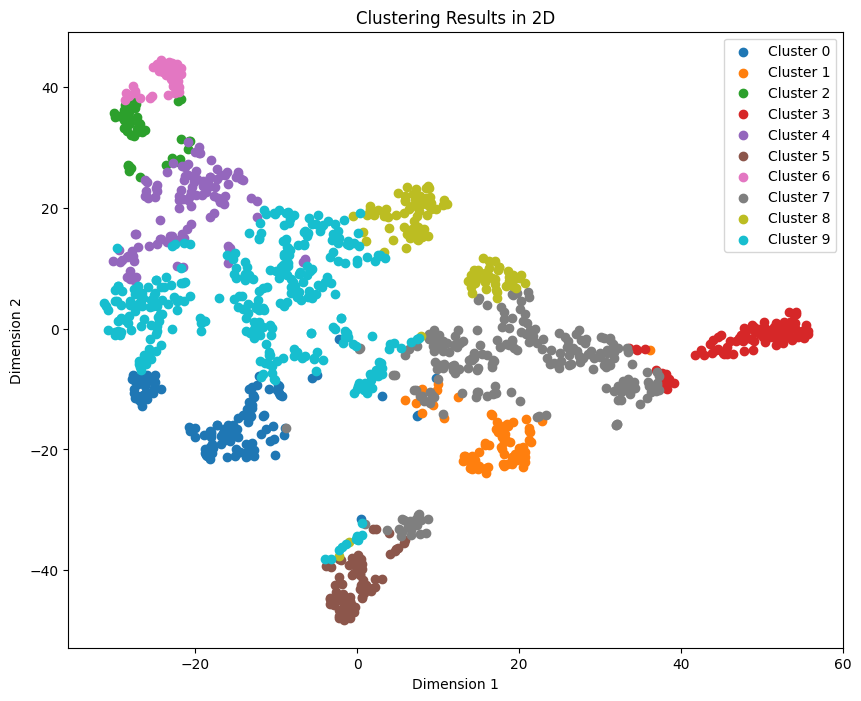

In [48]:
show_cluster_graph(encoded_ts, exp2_df['cluster_10'])